In [14]:
import numpy as np
import os
import pandas as pd
import datetime
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def getData():
    #stockData = yf.download(stocks, start = start, end = end)
    #stockData = stockData['Close']
    stockData = pd.read_csv("/Users/iliasrazig/Documents/mbf3/Mémoire/sp500.csv", header=[0], index_col=[0], parse_dates=True)
    topsectosp500 = pd.read_excel("/Users/iliasrazig/Documents/mbf3/Mémoire/stocks_list.xlsx")
    stocks = topsectosp500['Ticker Yahoo'].values.tolist()
    stockData = stockData[stocks]
    stockData = stockData.dropna()
    stockData = stockData.loc[stockData.index < '2023-08-01']
    
    return stockData


# Traitement des données en amont 
"""
Les prix comportent parfois des variations abruptes. Afin de faciliter la prédiction des prix par le modèle
nous allons lisser le jeu de données par du lissage exponentiel puisque la moyenne mobile par exemple comporte
quelques défauts pas de valeurs de début et de fin 
"""

def lissage_exponentiel(data, alpha):
    return data.ewm(alpha=alpha).mean()



2023-09-21 15:25:21.749495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:

def prediction_prix (data, fenetre, pct_train, ticker, nb_plis) : 

    #data = data.reset_index()

    # Prétraitement des données
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)


    # Sélectionner la colonne des prix de clôture comme étiquettes (y)
    y = data_scaled
    print(len(data_scaled))

    # Diviser les données en ensembles d'entraînement et de test (80% d'entraînement, 20% de test)
    split_index = int(len(y) * pct_train)
    y_train, y_test = y[:split_index], y[split_index:]


    # Paramètres pour la validation croisée
    #nb_plis = 5  # Nombre de plis pour la validation croisée
    #fenetre = 126  # Longueur de la séquence temporelle

    # Préparation des données de test pour les séquences temporelles
    #X_test = [y_test[i:i+fenetre] for i in range(len(y_test) - fenetre)]
    #X_test = np.array(X_test)

    # Préparation des données de test pour les séquences temporelles
    X_test = [y_test[i:i+fenetre] for i in range(len(y_test) - fenetre + 1)]
    X_test = np.array(X_test)
    print(X_test.shape)

    # Créer un objet TimeSeriesSplit pour la validation croisée Day Forward-Chaining
    tscv = TimeSeriesSplit(n_splits=nb_plis)

    # Initialiser une liste pour stocker les scores de validation
    validation_scores = []
    training_errors = []

    # Construction du modèle
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(fenetre, 1)),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Boucle de validation croisée Day Forward-Chaining
    for train_index, val_index in tscv.split(y_train):
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        print(y_train_fold.shape)
        print(y_val_fold.shape)
        # Préparation des données pour les séquences temporelles
        X_train_sequences = [y_train_fold[i:i+fenetre] for i in range(len(y_train_fold) - fenetre)]
        y_train_sequences = [y_train_fold[i+fenetre] for i in range(len(y_train_fold) - fenetre)]
        
        X_train_sequences = np.array(X_train_sequences)
        y_train_sequences = np.array(y_train_sequences)
    
        

      # Boucle pour chaque époque
        for epoch in range(10):  # 12 époques, vous pouvez ajuster ce nombre
            # Entraînement du modèle pour une époque
            history = model.fit(X_train_sequences, y_train_sequences, epochs=1, batch_size=32, verbose=0)

            # Calcul de l'erreur d'entraînement pour cette époque
            training_errors.append(history.history['loss'][0])

            # Calcul de la perte sur l'ensemble de validation pour cette époque
            X_val_sequences = [y_val_fold[i:i+fenetre] for i in range(len(y_val_fold) - fenetre)]
            y_val_sequences = [y_val_fold[i+fenetre] for i in range(len(y_val_fold) - fenetre)]

            X_val_sequences = np.array(X_val_sequences)
            y_val_sequences = np.array(y_val_sequences)

            y_val_pred = model.predict(X_val_sequences)
            val_score = mean_squared_error(y_val_sequences, y_val_pred)
            validation_scores.append(val_score)


   # Calculer la moyenne des erreurs d'entraînement pour chaque époque
    

    # Afficher la courbe d'apprentissage
    plt.figure(figsize=(12, 6))
    plt.plot(training_errors, label='Average Training Error')
    plt.plot(validation_scores, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Courbe d\'apprentissage')
    plt.legend()
    plt.show()

    # Afficher les scores de validation
    for i, score in enumerate(validation_scores):
        print(f'Fold {i+1} Validation Score: {score:.4f}')

    # Calcul de la moyenne des scores de validation
    average_validation_score = np.mean(validation_scores)
    print(f'Average Validation Score: {average_validation_score:.4f}')


    # Créer un DataFrame à partir des scores de validation
    score_df = pd.DataFrame({ticker: validation_scores})

    # Nom du fichier CSV
    csv_filename = 'validation_scores.csv'

    # Si le fichier CSV n'existe pas, créez-le
    if not os.path.exists(csv_filename):
        score_df.to_csv(csv_filename, index=False)
    else:
        # Si le fichier CSV existe, ajoutez les données au DataFrame existant
        existing_df = pd.read_csv(csv_filename)
        existing_df[ticker] = score_df[ticker]
        existing_df.to_csv(csv_filename, index=False)

    print(f"Les scores de validation ont été enregistrés dans {csv_filename}")


    # Créer un DataFrame à partir des erreurs d'entraînement
    score_df = pd.DataFrame({ticker: training_errors})

    # Nom du fichier CSV
    csv_filename = 'erreurs_train.csv'

    # Si le fichier CSV n'existe pas, créez-le
    if not os.path.exists(csv_filename):
        score_df.to_csv(csv_filename, index=False)
    else:
        # Si le fichier CSV existe, ajoutez les données au DataFrame existant
        existing_df = pd.read_csv(csv_filename)
        existing_df[ticker] = score_df[ticker]
        existing_df.to_csv(csv_filename, index=False)

    print(f"Les erreurs d'entraînement ont été enregistrés dans {csv_filename}")

    # Prédiction
    predicted_scaled = model.predict(X_test)
    predicted = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predicted_scaled), axis=1))[:, -1]

    # Création des dates pour les prédictions 
    predicted_dates = data.index[len(data) - len(predicted):]
    predicted_data = pd.DataFrame(data = predicted, index = predicted_dates, columns = ["Prix predits"])
    predicted_data.to_csv('/Users/iliasrazig/Documents/mbf3/Mémoire/Prédictions/predictions' + str(ticker) + '.csv')

    # Visualisation des résultats

    # Afficher les prix utilisés pour l'entraînement et les prix prédits dans un graphique
    plt.figure(figsize=(12, 6))
    plt.plot(data[len(data)-len(predicted):], label='Prix historiques')
    plt.plot(predicted_dates, predicted, label='Prix prédits')
    plt.xlabel('Temps')
    plt.ylabel('Cours')
    plt.title('Evolution des prix historiques et prédits de ' + str(ticker))
    plt.legend()
    plt.savefig('/Users/iliasrazig/Documents/mbf3/Mémoire/graphs/' + str(ticker) + '.png')
    plt.show()


2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 36ms/step


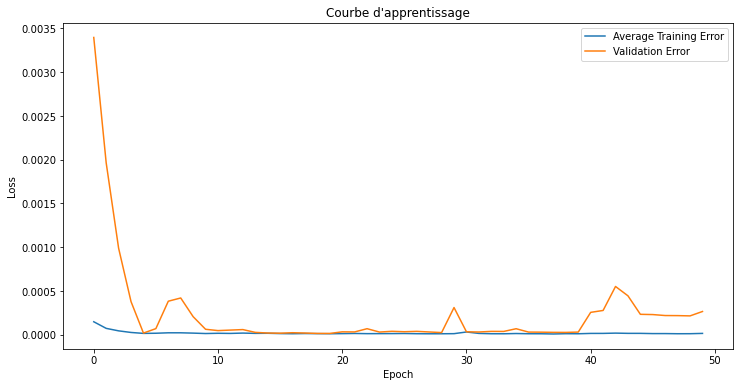

Fold 1 Validation Score: 0.0034
Fold 2 Validation Score: 0.0020
Fold 3 Validation Score: 0.0010
Fold 4 Validation Score: 0.0004
Fold 5 Validation Score: 0.0000
Fold 6 Validation Score: 0.0001
Fold 7 Validation Score: 0.0004
Fold 8 Validation Score: 0.0004
Fold 9 Validation Score: 0.0002
Fold 10 Validation Score: 0.0001
Fold 11 Validation Score: 0.0000
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0000
Fold 15 Validation Score: 0.0000
Fold 16 Validation Score: 0.0000
Fold 17 Validation Score: 0.0000
Fold 18 Validation Score: 0.0000
Fold 19 Validation Score: 0.0000
Fold 20 Validation Score: 0.0000
Fold 21 Validation Score: 0.0000
Fold 22 Validation Score: 0.0000
Fold 23 Validation Score: 0.0001
Fold 24 Validation Score: 0.0000
Fold 25 Validation Score: 0.0000
Fold 26 Validation Score: 0.0000
Fold 27 Validation Score: 0.0000
Fold 28 Validation Score: 0.0000
Fold 29 Validation Score: 0.0000
Fold 30 Validation Score: 0.0003
Fold 31 Validation 

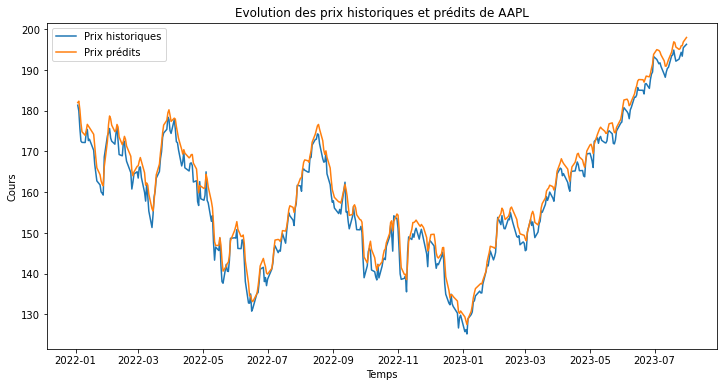

1 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 1s 76ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 47ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 45ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step


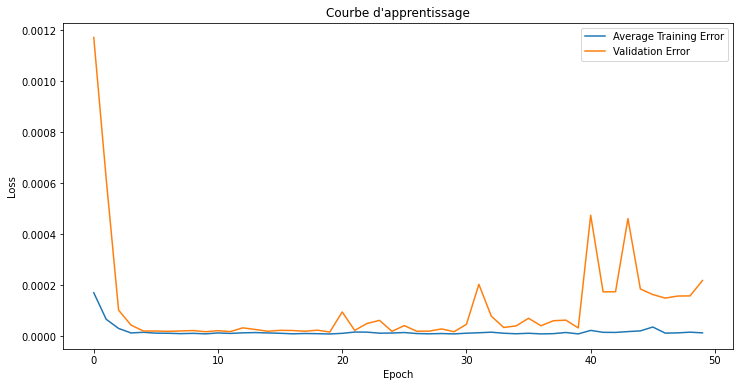

Fold 1 Validation Score: 0.0012
Fold 2 Validation Score: 0.0006
Fold 3 Validation Score: 0.0001
Fold 4 Validation Score: 0.0000
Fold 5 Validation Score: 0.0000
Fold 6 Validation Score: 0.0000
Fold 7 Validation Score: 0.0000
Fold 8 Validation Score: 0.0000
Fold 9 Validation Score: 0.0000
Fold 10 Validation Score: 0.0000
Fold 11 Validation Score: 0.0000
Fold 12 Validation Score: 0.0000
Fold 13 Validation Score: 0.0000
Fold 14 Validation Score: 0.0000
Fold 15 Validation Score: 0.0000
Fold 16 Validation Score: 0.0000
Fold 17 Validation Score: 0.0000
Fold 18 Validation Score: 0.0000
Fold 19 Validation Score: 0.0000
Fold 20 Validation Score: 0.0000
Fold 21 Validation Score: 0.0001
Fold 22 Validation Score: 0.0000
Fold 23 Validation Score: 0.0001
Fold 24 Validation Score: 0.0001
Fold 25 Validation Score: 0.0000
Fold 26 Validation Score: 0.0000
Fold 27 Validation Score: 0.0000
Fold 28 Validation Score: 0.0000
Fold 29 Validation Score: 0.0000
Fold 30 Validation Score: 0.0000
Fold 31 Validation 

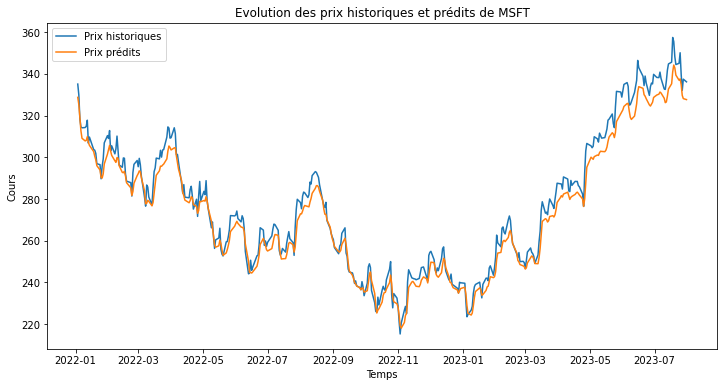

2 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 1s 69ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 39ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 49ms/step


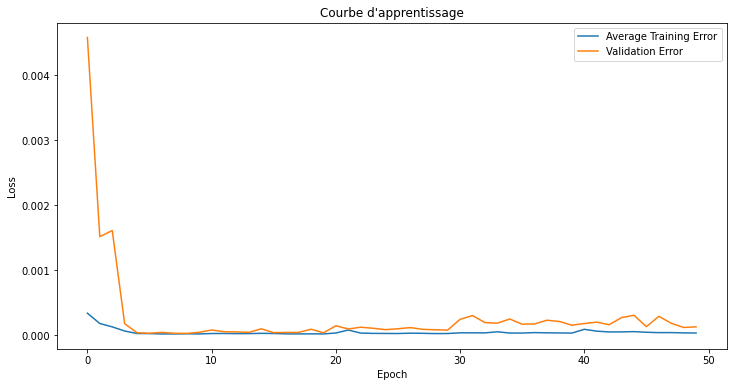

Fold 1 Validation Score: 0.0046
Fold 2 Validation Score: 0.0015
Fold 3 Validation Score: 0.0016
Fold 4 Validation Score: 0.0002
Fold 5 Validation Score: 0.0000
Fold 6 Validation Score: 0.0000
Fold 7 Validation Score: 0.0000
Fold 8 Validation Score: 0.0000
Fold 9 Validation Score: 0.0000
Fold 10 Validation Score: 0.0000
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0000
Fold 14 Validation Score: 0.0000
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0000
Fold 17 Validation Score: 0.0000
Fold 18 Validation Score: 0.0000
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0000
Fold 21 Validation Score: 0.0001
Fold 22 Validation Score: 0.0001
Fold 23 Validation Score: 0.0001
Fold 24 Validation Score: 0.0001
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0001
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0001
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

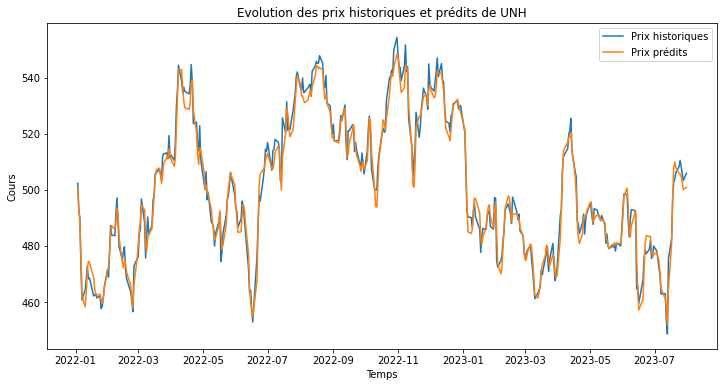

3 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 53ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 48ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 49ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step


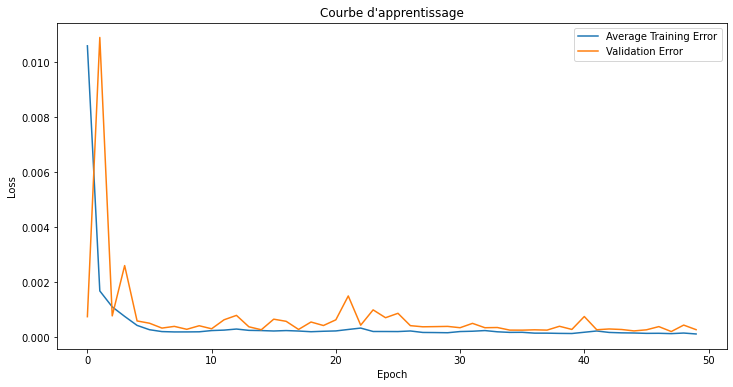

Fold 1 Validation Score: 0.0007
Fold 2 Validation Score: 0.0109
Fold 3 Validation Score: 0.0008
Fold 4 Validation Score: 0.0026
Fold 5 Validation Score: 0.0006
Fold 6 Validation Score: 0.0005
Fold 7 Validation Score: 0.0003
Fold 8 Validation Score: 0.0004
Fold 9 Validation Score: 0.0003
Fold 10 Validation Score: 0.0004
Fold 11 Validation Score: 0.0003
Fold 12 Validation Score: 0.0006
Fold 13 Validation Score: 0.0008
Fold 14 Validation Score: 0.0004
Fold 15 Validation Score: 0.0003
Fold 16 Validation Score: 0.0007
Fold 17 Validation Score: 0.0006
Fold 18 Validation Score: 0.0003
Fold 19 Validation Score: 0.0006
Fold 20 Validation Score: 0.0004
Fold 21 Validation Score: 0.0006
Fold 22 Validation Score: 0.0015
Fold 23 Validation Score: 0.0004
Fold 24 Validation Score: 0.0010
Fold 25 Validation Score: 0.0007
Fold 26 Validation Score: 0.0009
Fold 27 Validation Score: 0.0004
Fold 28 Validation Score: 0.0004
Fold 29 Validation Score: 0.0004
Fold 30 Validation Score: 0.0004
Fold 31 Validation 

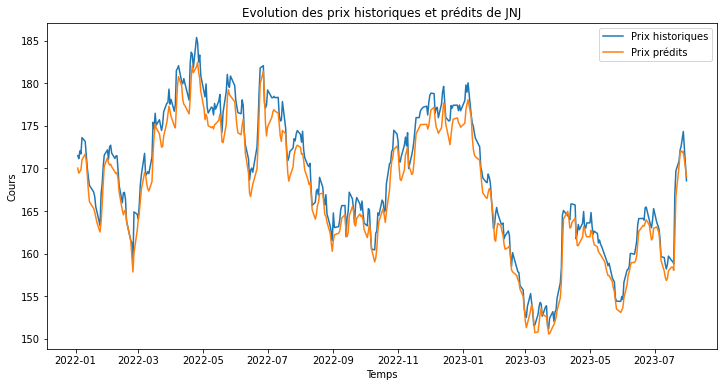

4 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 39ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 49ms/step


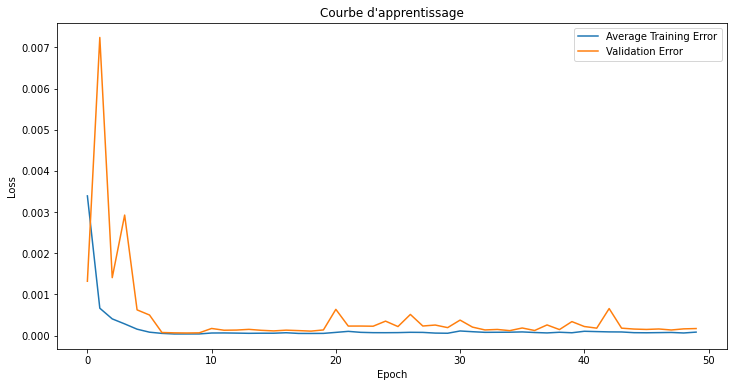

Fold 1 Validation Score: 0.0013
Fold 2 Validation Score: 0.0072
Fold 3 Validation Score: 0.0014
Fold 4 Validation Score: 0.0029
Fold 5 Validation Score: 0.0006
Fold 6 Validation Score: 0.0005
Fold 7 Validation Score: 0.0001
Fold 8 Validation Score: 0.0001
Fold 9 Validation Score: 0.0001
Fold 10 Validation Score: 0.0001
Fold 11 Validation Score: 0.0002
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0006
Fold 22 Validation Score: 0.0002
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0002
Fold 25 Validation Score: 0.0003
Fold 26 Validation Score: 0.0002
Fold 27 Validation Score: 0.0005
Fold 28 Validation Score: 0.0002
Fold 29 Validation Score: 0.0003
Fold 30 Validation Score: 0.0002
Fold 31 Validation 

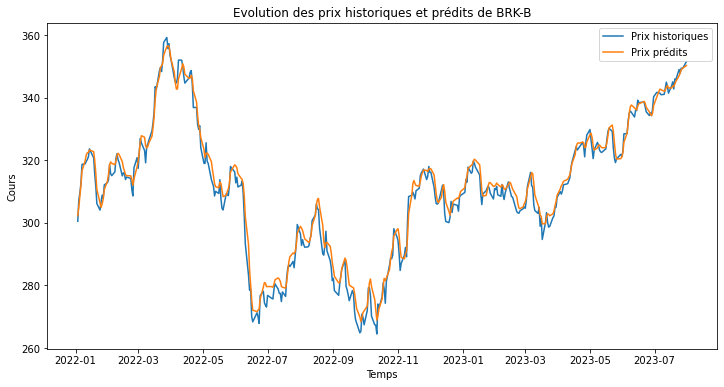

5 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 46ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 48ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 42ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 35ms/step


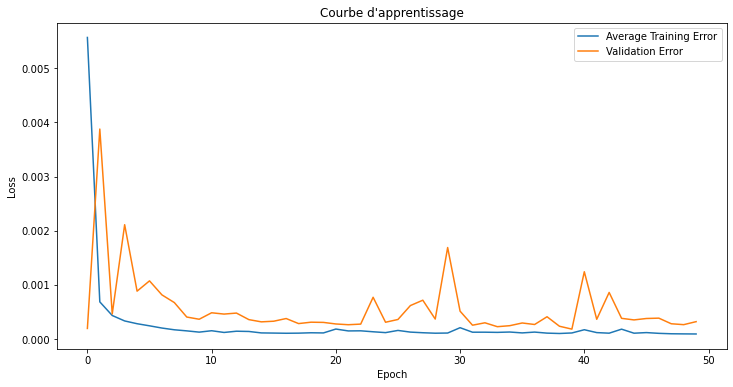

Fold 1 Validation Score: 0.0002
Fold 2 Validation Score: 0.0039
Fold 3 Validation Score: 0.0005
Fold 4 Validation Score: 0.0021
Fold 5 Validation Score: 0.0009
Fold 6 Validation Score: 0.0011
Fold 7 Validation Score: 0.0008
Fold 8 Validation Score: 0.0007
Fold 9 Validation Score: 0.0004
Fold 10 Validation Score: 0.0004
Fold 11 Validation Score: 0.0005
Fold 12 Validation Score: 0.0005
Fold 13 Validation Score: 0.0005
Fold 14 Validation Score: 0.0004
Fold 15 Validation Score: 0.0003
Fold 16 Validation Score: 0.0003
Fold 17 Validation Score: 0.0004
Fold 18 Validation Score: 0.0003
Fold 19 Validation Score: 0.0003
Fold 20 Validation Score: 0.0003
Fold 21 Validation Score: 0.0003
Fold 22 Validation Score: 0.0003
Fold 23 Validation Score: 0.0003
Fold 24 Validation Score: 0.0008
Fold 25 Validation Score: 0.0003
Fold 26 Validation Score: 0.0004
Fold 27 Validation Score: 0.0006
Fold 28 Validation Score: 0.0007
Fold 29 Validation Score: 0.0004
Fold 30 Validation Score: 0.0017
Fold 31 Validation 

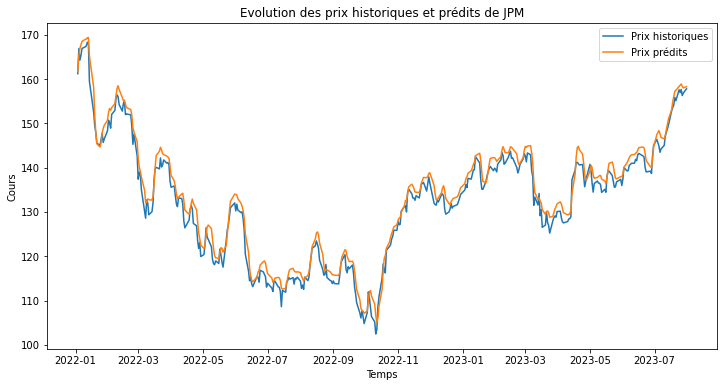

6 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 39ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 45ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 43ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 42ms/step


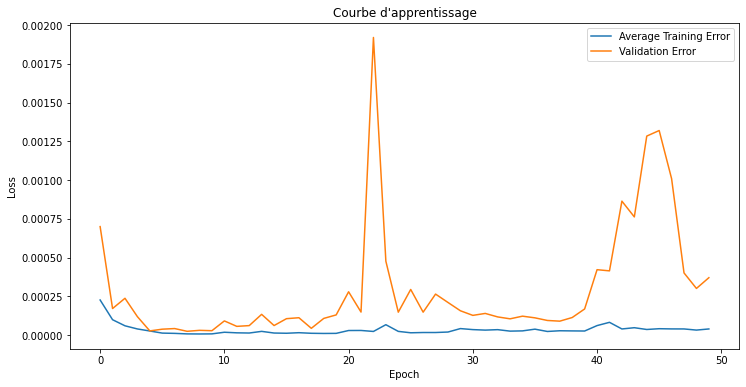

Fold 1 Validation Score: 0.0007
Fold 2 Validation Score: 0.0002
Fold 3 Validation Score: 0.0002
Fold 4 Validation Score: 0.0001
Fold 5 Validation Score: 0.0000
Fold 6 Validation Score: 0.0000
Fold 7 Validation Score: 0.0000
Fold 8 Validation Score: 0.0000
Fold 9 Validation Score: 0.0000
Fold 10 Validation Score: 0.0000
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0000
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0003
Fold 22 Validation Score: 0.0001
Fold 23 Validation Score: 0.0019
Fold 24 Validation Score: 0.0005
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0003
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0003
Fold 29 Validation Score: 0.0002
Fold 30 Validation Score: 0.0002
Fold 31 Validation 

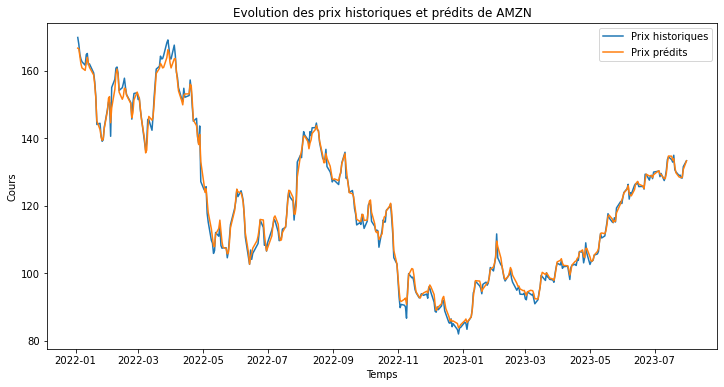

7 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 36ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 50ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 51ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 38ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step


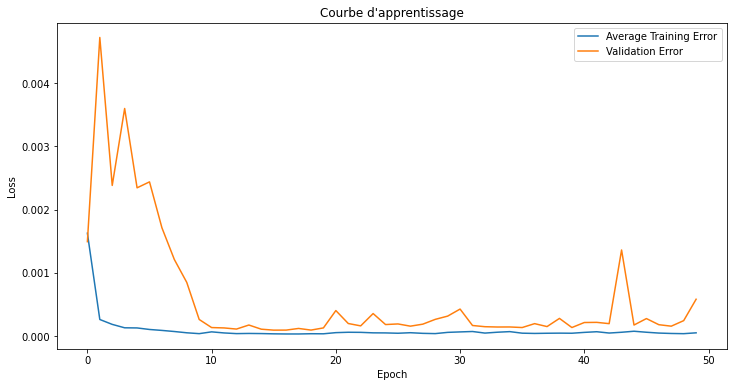

Fold 1 Validation Score: 0.0015
Fold 2 Validation Score: 0.0047
Fold 3 Validation Score: 0.0024
Fold 4 Validation Score: 0.0036
Fold 5 Validation Score: 0.0023
Fold 6 Validation Score: 0.0024
Fold 7 Validation Score: 0.0017
Fold 8 Validation Score: 0.0012
Fold 9 Validation Score: 0.0008
Fold 10 Validation Score: 0.0003
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0002
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0004
Fold 22 Validation Score: 0.0002
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0004
Fold 25 Validation Score: 0.0002
Fold 26 Validation Score: 0.0002
Fold 27 Validation Score: 0.0002
Fold 28 Validation Score: 0.0002
Fold 29 Validation Score: 0.0003
Fold 30 Validation Score: 0.0003
Fold 31 Validation 

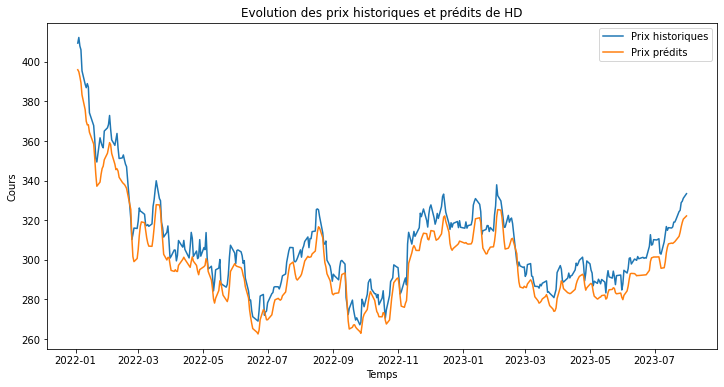

8 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 36ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 39ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 36ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 39ms/step


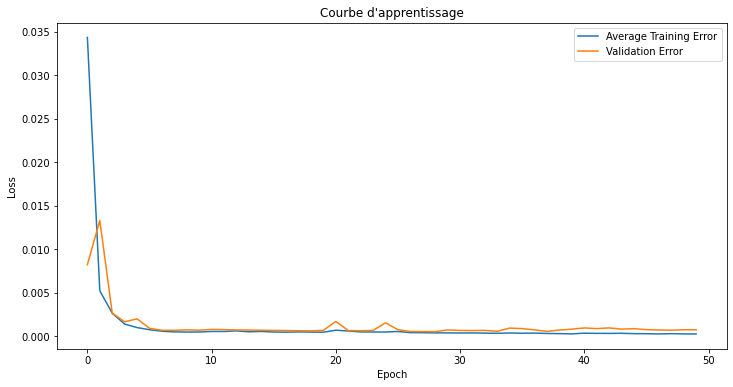

Fold 1 Validation Score: 0.0082
Fold 2 Validation Score: 0.0133
Fold 3 Validation Score: 0.0027
Fold 4 Validation Score: 0.0017
Fold 5 Validation Score: 0.0020
Fold 6 Validation Score: 0.0009
Fold 7 Validation Score: 0.0007
Fold 8 Validation Score: 0.0007
Fold 9 Validation Score: 0.0008
Fold 10 Validation Score: 0.0007
Fold 11 Validation Score: 0.0008
Fold 12 Validation Score: 0.0008
Fold 13 Validation Score: 0.0007
Fold 14 Validation Score: 0.0007
Fold 15 Validation Score: 0.0007
Fold 16 Validation Score: 0.0007
Fold 17 Validation Score: 0.0007
Fold 18 Validation Score: 0.0007
Fold 19 Validation Score: 0.0006
Fold 20 Validation Score: 0.0007
Fold 21 Validation Score: 0.0017
Fold 22 Validation Score: 0.0007
Fold 23 Validation Score: 0.0007
Fold 24 Validation Score: 0.0007
Fold 25 Validation Score: 0.0016
Fold 26 Validation Score: 0.0008
Fold 27 Validation Score: 0.0006
Fold 28 Validation Score: 0.0006
Fold 29 Validation Score: 0.0006
Fold 30 Validation Score: 0.0007
Fold 31 Validation 

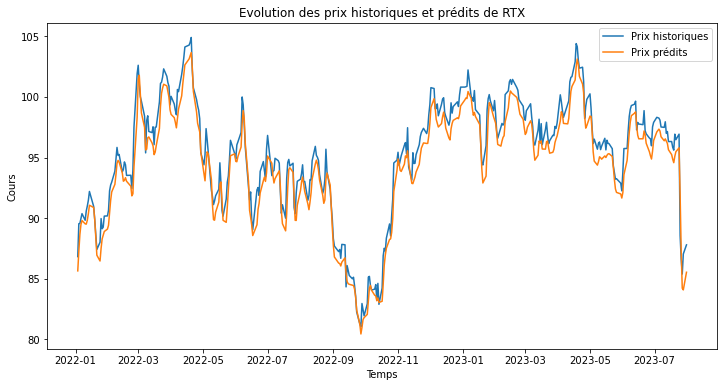

9 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 58ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 39ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 59ms/step


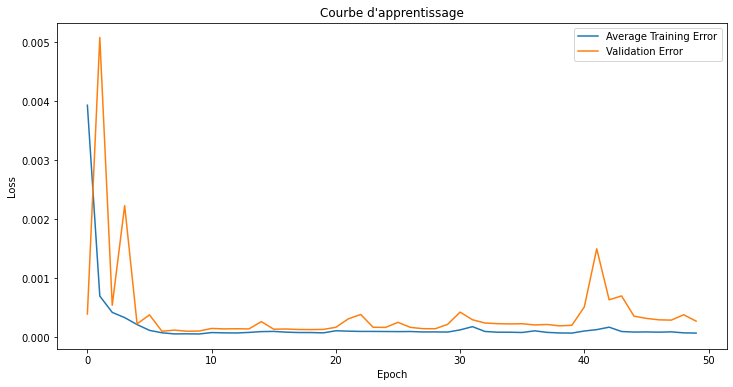

Fold 1 Validation Score: 0.0004
Fold 2 Validation Score: 0.0051
Fold 3 Validation Score: 0.0005
Fold 4 Validation Score: 0.0022
Fold 5 Validation Score: 0.0002
Fold 6 Validation Score: 0.0004
Fold 7 Validation Score: 0.0001
Fold 8 Validation Score: 0.0001
Fold 9 Validation Score: 0.0001
Fold 10 Validation Score: 0.0001
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0003
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0002
Fold 22 Validation Score: 0.0003
Fold 23 Validation Score: 0.0004
Fold 24 Validation Score: 0.0002
Fold 25 Validation Score: 0.0002
Fold 26 Validation Score: 0.0003
Fold 27 Validation Score: 0.0002
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0001
Fold 30 Validation Score: 0.0002
Fold 31 Validation 

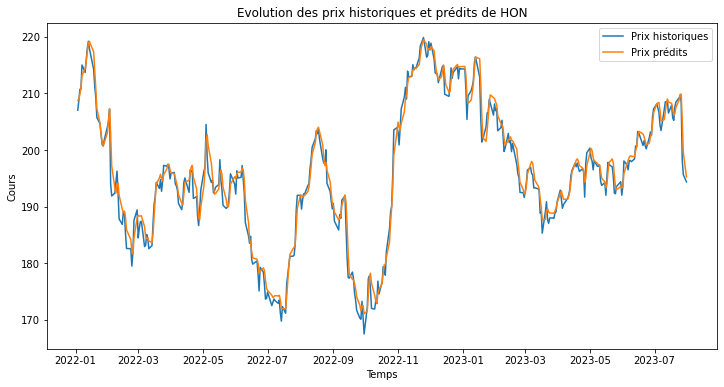

10 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 1s 63ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 34ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step


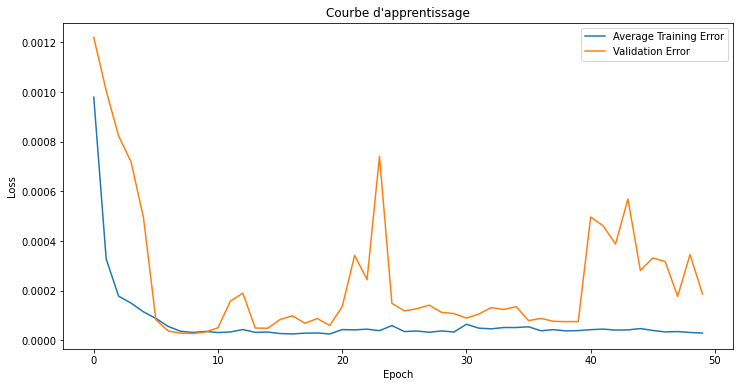

Fold 1 Validation Score: 0.0012
Fold 2 Validation Score: 0.0010
Fold 3 Validation Score: 0.0008
Fold 4 Validation Score: 0.0007
Fold 5 Validation Score: 0.0005
Fold 6 Validation Score: 0.0001
Fold 7 Validation Score: 0.0000
Fold 8 Validation Score: 0.0000
Fold 9 Validation Score: 0.0000
Fold 10 Validation Score: 0.0000
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0002
Fold 13 Validation Score: 0.0002
Fold 14 Validation Score: 0.0000
Fold 15 Validation Score: 0.0000
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0001
Fold 22 Validation Score: 0.0003
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0007
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0001
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0001
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

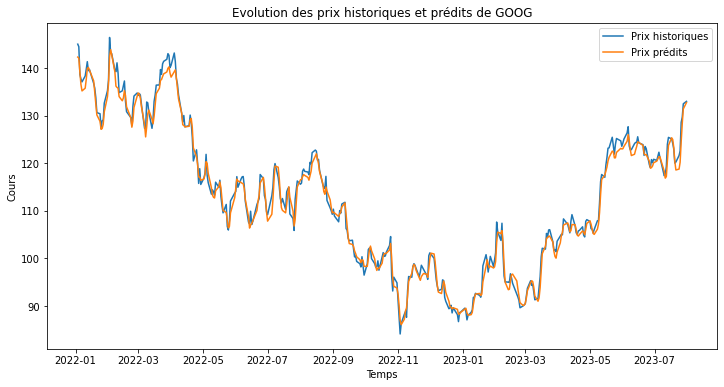

11 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 30ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step


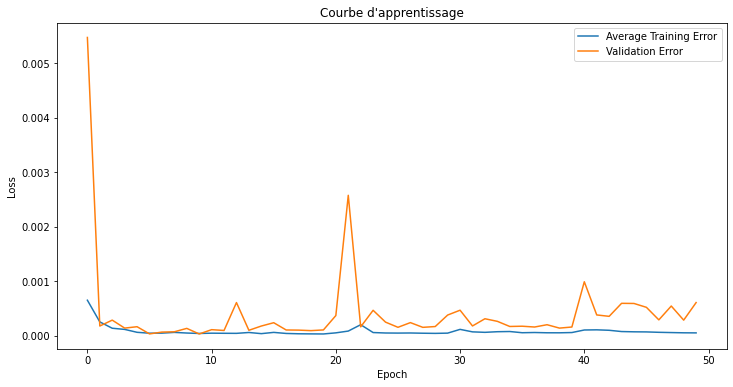

Fold 1 Validation Score: 0.0055
Fold 2 Validation Score: 0.0002
Fold 3 Validation Score: 0.0003
Fold 4 Validation Score: 0.0001
Fold 5 Validation Score: 0.0002
Fold 6 Validation Score: 0.0000
Fold 7 Validation Score: 0.0001
Fold 8 Validation Score: 0.0001
Fold 9 Validation Score: 0.0001
Fold 10 Validation Score: 0.0000
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0006
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0002
Fold 16 Validation Score: 0.0002
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0004
Fold 22 Validation Score: 0.0026
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0005
Fold 25 Validation Score: 0.0002
Fold 26 Validation Score: 0.0002
Fold 27 Validation Score: 0.0002
Fold 28 Validation Score: 0.0002
Fold 29 Validation Score: 0.0002
Fold 30 Validation Score: 0.0004
Fold 31 Validation 

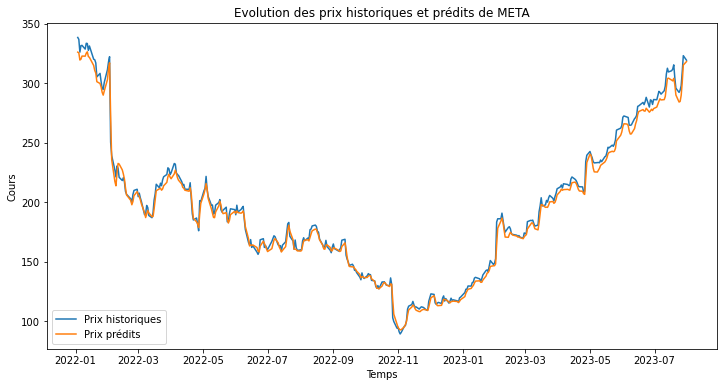

12 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 44ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 45ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 47ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 35ms/step


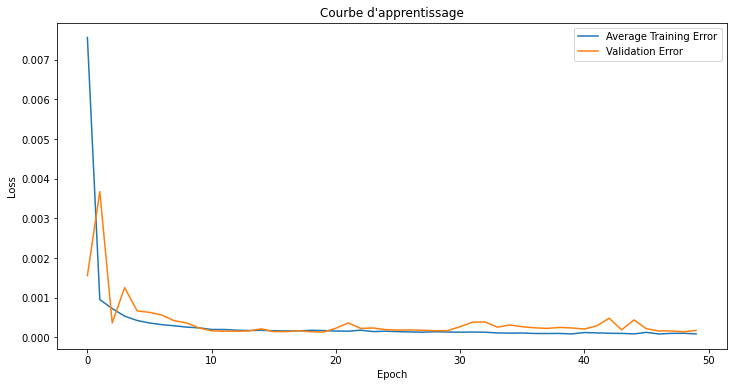

Fold 1 Validation Score: 0.0016
Fold 2 Validation Score: 0.0037
Fold 3 Validation Score: 0.0004
Fold 4 Validation Score: 0.0013
Fold 5 Validation Score: 0.0007
Fold 6 Validation Score: 0.0006
Fold 7 Validation Score: 0.0006
Fold 8 Validation Score: 0.0004
Fold 9 Validation Score: 0.0004
Fold 10 Validation Score: 0.0002
Fold 11 Validation Score: 0.0002
Fold 12 Validation Score: 0.0002
Fold 13 Validation Score: 0.0002
Fold 14 Validation Score: 0.0002
Fold 15 Validation Score: 0.0002
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0002
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0002
Fold 22 Validation Score: 0.0004
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0002
Fold 25 Validation Score: 0.0002
Fold 26 Validation Score: 0.0002
Fold 27 Validation Score: 0.0002
Fold 28 Validation Score: 0.0002
Fold 29 Validation Score: 0.0002
Fold 30 Validation Score: 0.0002
Fold 31 Validation 

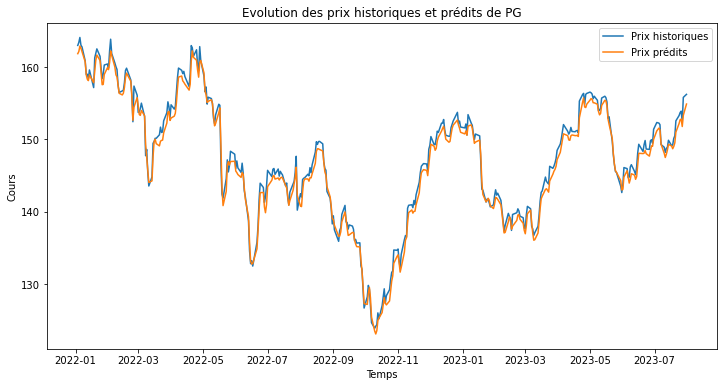

13 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 30ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 58ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 31ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 25ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 24ms/step


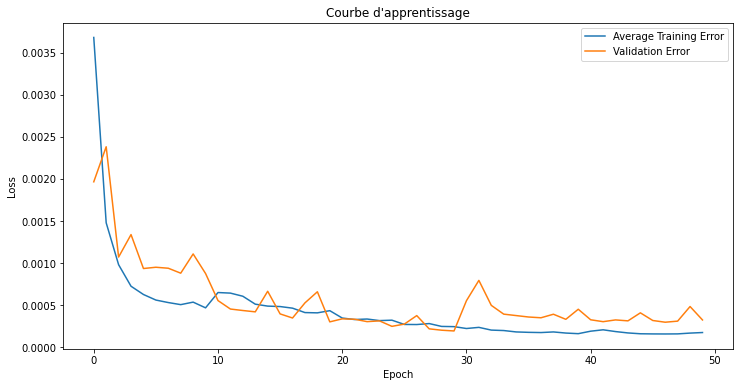

Fold 1 Validation Score: 0.0020
Fold 2 Validation Score: 0.0024
Fold 3 Validation Score: 0.0011
Fold 4 Validation Score: 0.0013
Fold 5 Validation Score: 0.0009
Fold 6 Validation Score: 0.0009
Fold 7 Validation Score: 0.0009
Fold 8 Validation Score: 0.0009
Fold 9 Validation Score: 0.0011
Fold 10 Validation Score: 0.0009
Fold 11 Validation Score: 0.0006
Fold 12 Validation Score: 0.0005
Fold 13 Validation Score: 0.0004
Fold 14 Validation Score: 0.0004
Fold 15 Validation Score: 0.0007
Fold 16 Validation Score: 0.0004
Fold 17 Validation Score: 0.0003
Fold 18 Validation Score: 0.0005
Fold 19 Validation Score: 0.0007
Fold 20 Validation Score: 0.0003
Fold 21 Validation Score: 0.0003
Fold 22 Validation Score: 0.0003
Fold 23 Validation Score: 0.0003
Fold 24 Validation Score: 0.0003
Fold 25 Validation Score: 0.0002
Fold 26 Validation Score: 0.0003
Fold 27 Validation Score: 0.0004
Fold 28 Validation Score: 0.0002
Fold 29 Validation Score: 0.0002
Fold 30 Validation Score: 0.0002
Fold 31 Validation 

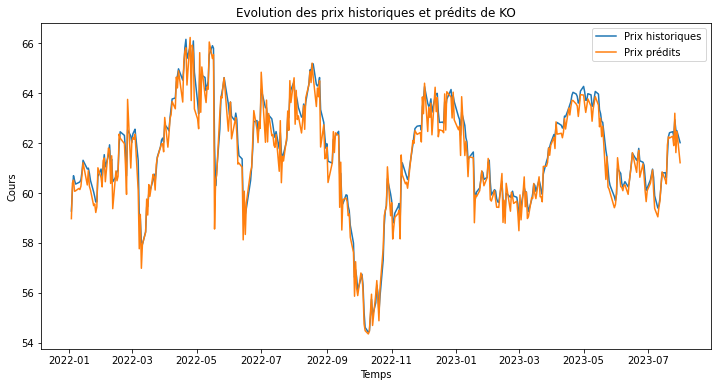

14 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 1s 79ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 38ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 34ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 34ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 1s 64ms/step


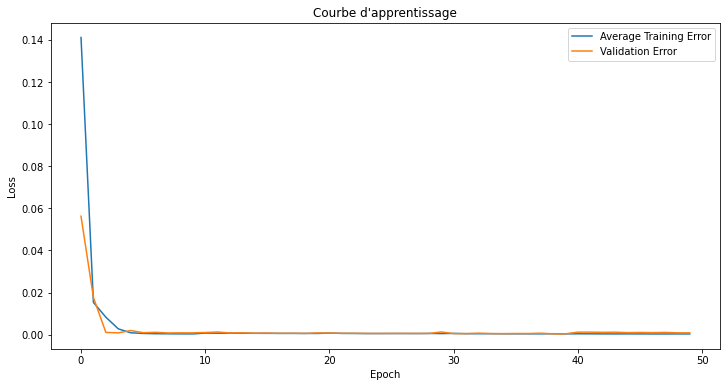

Fold 1 Validation Score: 0.0563
Fold 2 Validation Score: 0.0177
Fold 3 Validation Score: 0.0011
Fold 4 Validation Score: 0.0009
Fold 5 Validation Score: 0.0020
Fold 6 Validation Score: 0.0009
Fold 7 Validation Score: 0.0011
Fold 8 Validation Score: 0.0008
Fold 9 Validation Score: 0.0009
Fold 10 Validation Score: 0.0009
Fold 11 Validation Score: 0.0010
Fold 12 Validation Score: 0.0013
Fold 13 Validation Score: 0.0008
Fold 14 Validation Score: 0.0009
Fold 15 Validation Score: 0.0007
Fold 16 Validation Score: 0.0008
Fold 17 Validation Score: 0.0006
Fold 18 Validation Score: 0.0007
Fold 19 Validation Score: 0.0006
Fold 20 Validation Score: 0.0008
Fold 21 Validation Score: 0.0008
Fold 22 Validation Score: 0.0007
Fold 23 Validation Score: 0.0007
Fold 24 Validation Score: 0.0006
Fold 25 Validation Score: 0.0006
Fold 26 Validation Score: 0.0006
Fold 27 Validation Score: 0.0006
Fold 28 Validation Score: 0.0006
Fold 29 Validation Score: 0.0006
Fold 30 Validation Score: 0.0013
Fold 31 Validation 

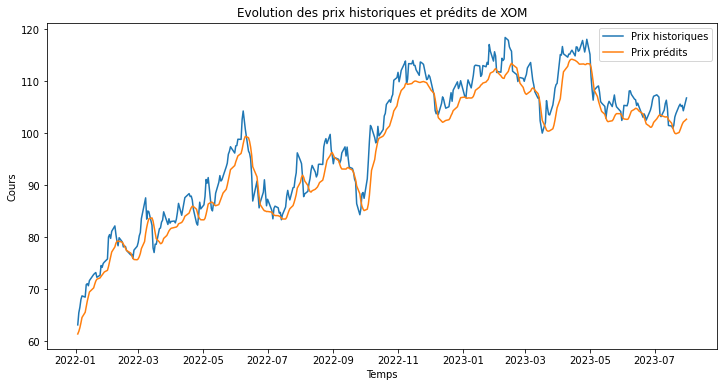

15 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 1s 57ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step


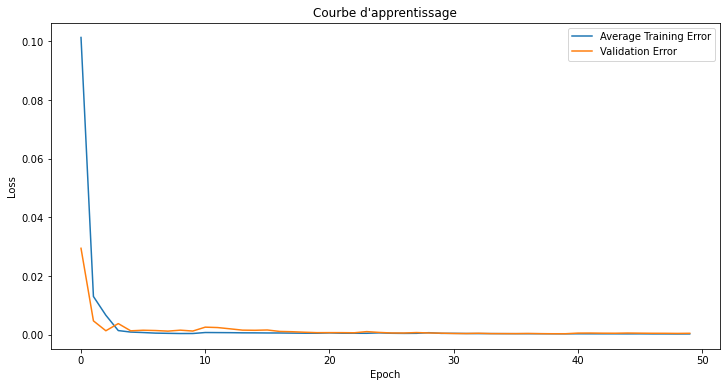

Fold 1 Validation Score: 0.0294
Fold 2 Validation Score: 0.0047
Fold 3 Validation Score: 0.0013
Fold 4 Validation Score: 0.0038
Fold 5 Validation Score: 0.0013
Fold 6 Validation Score: 0.0015
Fold 7 Validation Score: 0.0014
Fold 8 Validation Score: 0.0012
Fold 9 Validation Score: 0.0015
Fold 10 Validation Score: 0.0012
Fold 11 Validation Score: 0.0026
Fold 12 Validation Score: 0.0024
Fold 13 Validation Score: 0.0020
Fold 14 Validation Score: 0.0015
Fold 15 Validation Score: 0.0015
Fold 16 Validation Score: 0.0016
Fold 17 Validation Score: 0.0011
Fold 18 Validation Score: 0.0010
Fold 19 Validation Score: 0.0008
Fold 20 Validation Score: 0.0007
Fold 21 Validation Score: 0.0007
Fold 22 Validation Score: 0.0007
Fold 23 Validation Score: 0.0006
Fold 24 Validation Score: 0.0010
Fold 25 Validation Score: 0.0008
Fold 26 Validation Score: 0.0006
Fold 27 Validation Score: 0.0006
Fold 28 Validation Score: 0.0007
Fold 29 Validation Score: 0.0006
Fold 30 Validation Score: 0.0005
Fold 31 Validation 

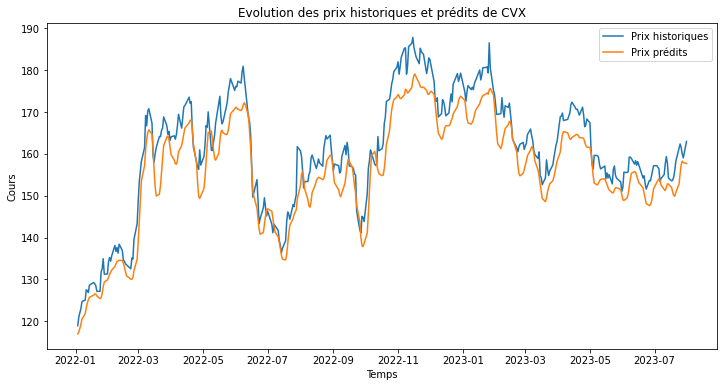

16 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 1s 67ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 42ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 32ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 35ms/step


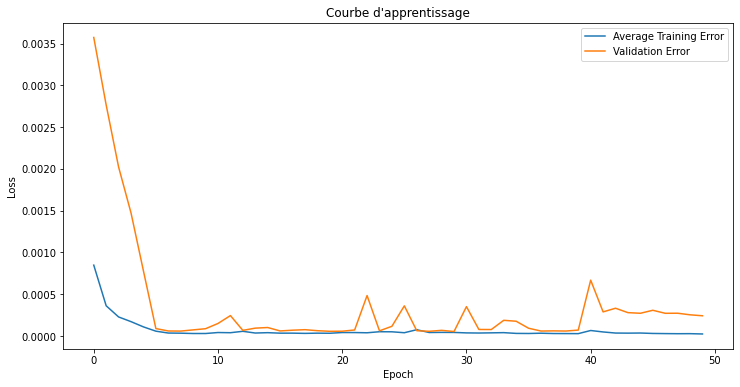

Fold 1 Validation Score: 0.0036
Fold 2 Validation Score: 0.0028
Fold 3 Validation Score: 0.0020
Fold 4 Validation Score: 0.0015
Fold 5 Validation Score: 0.0008
Fold 6 Validation Score: 0.0001
Fold 7 Validation Score: 0.0001
Fold 8 Validation Score: 0.0001
Fold 9 Validation Score: 0.0001
Fold 10 Validation Score: 0.0001
Fold 11 Validation Score: 0.0002
Fold 12 Validation Score: 0.0002
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0001
Fold 22 Validation Score: 0.0001
Fold 23 Validation Score: 0.0005
Fold 24 Validation Score: 0.0001
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0004
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0001
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

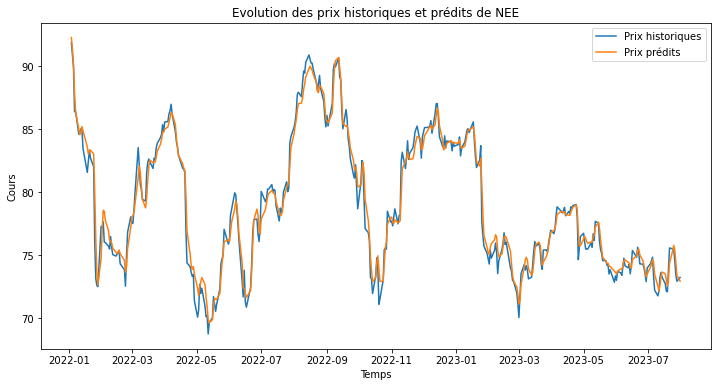

17 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 41ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 48ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 34ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step


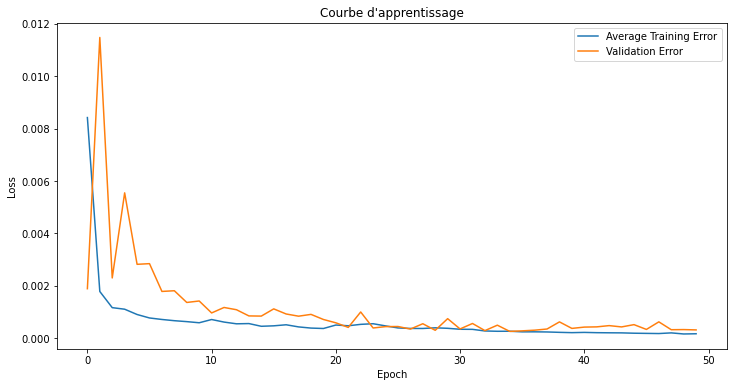

Fold 1 Validation Score: 0.0019
Fold 2 Validation Score: 0.0115
Fold 3 Validation Score: 0.0023
Fold 4 Validation Score: 0.0055
Fold 5 Validation Score: 0.0028
Fold 6 Validation Score: 0.0028
Fold 7 Validation Score: 0.0018
Fold 8 Validation Score: 0.0018
Fold 9 Validation Score: 0.0014
Fold 10 Validation Score: 0.0014
Fold 11 Validation Score: 0.0010
Fold 12 Validation Score: 0.0012
Fold 13 Validation Score: 0.0011
Fold 14 Validation Score: 0.0009
Fold 15 Validation Score: 0.0008
Fold 16 Validation Score: 0.0011
Fold 17 Validation Score: 0.0009
Fold 18 Validation Score: 0.0008
Fold 19 Validation Score: 0.0009
Fold 20 Validation Score: 0.0007
Fold 21 Validation Score: 0.0006
Fold 22 Validation Score: 0.0004
Fold 23 Validation Score: 0.0010
Fold 24 Validation Score: 0.0004
Fold 25 Validation Score: 0.0004
Fold 26 Validation Score: 0.0005
Fold 27 Validation Score: 0.0004
Fold 28 Validation Score: 0.0006
Fold 29 Validation Score: 0.0003
Fold 30 Validation Score: 0.0008
Fold 31 Validation 

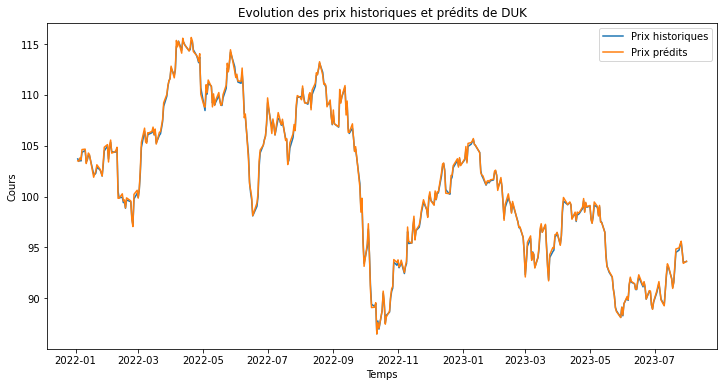

18 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 35ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 1s 59ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 47ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 36ms/step


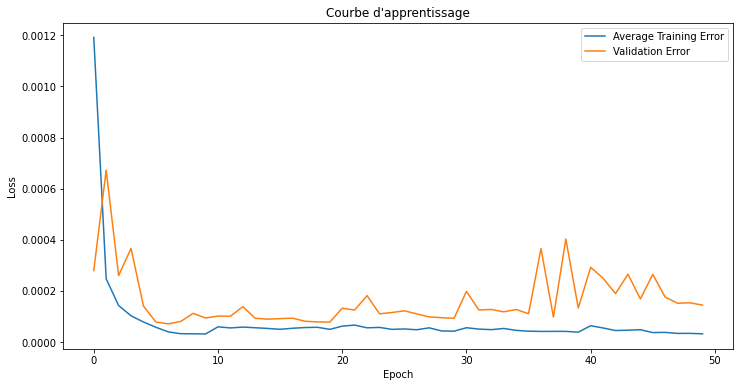

Fold 1 Validation Score: 0.0003
Fold 2 Validation Score: 0.0007
Fold 3 Validation Score: 0.0003
Fold 4 Validation Score: 0.0004
Fold 5 Validation Score: 0.0001
Fold 6 Validation Score: 0.0001
Fold 7 Validation Score: 0.0001
Fold 8 Validation Score: 0.0001
Fold 9 Validation Score: 0.0001
Fold 10 Validation Score: 0.0001
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0001
Fold 22 Validation Score: 0.0001
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0001
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0001
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0001
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

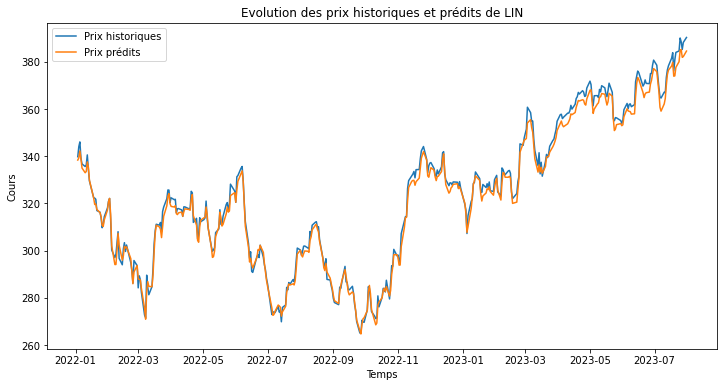

19 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 51ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 57ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 58ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 38ms/step


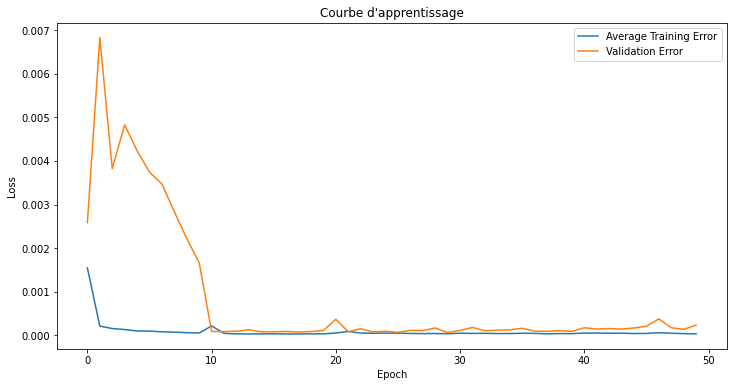

Fold 1 Validation Score: 0.0026
Fold 2 Validation Score: 0.0068
Fold 3 Validation Score: 0.0038
Fold 4 Validation Score: 0.0048
Fold 5 Validation Score: 0.0042
Fold 6 Validation Score: 0.0037
Fold 7 Validation Score: 0.0035
Fold 8 Validation Score: 0.0028
Fold 9 Validation Score: 0.0022
Fold 10 Validation Score: 0.0017
Fold 11 Validation Score: 0.0001
Fold 12 Validation Score: 0.0001
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0004
Fold 22 Validation Score: 0.0001
Fold 23 Validation Score: 0.0002
Fold 24 Validation Score: 0.0001
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0001
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0002
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

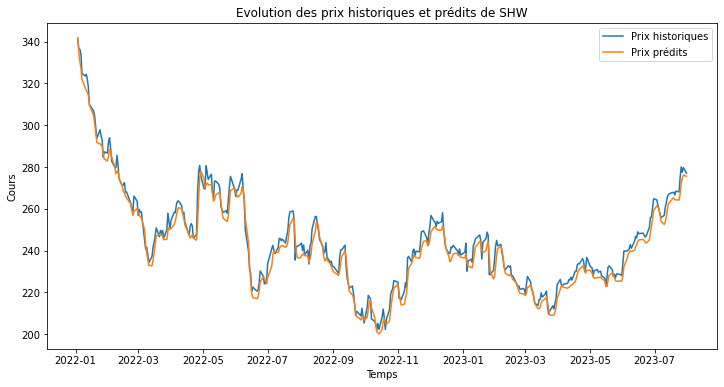

20 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 33ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 1s 80ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 34ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 55ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 36ms/step


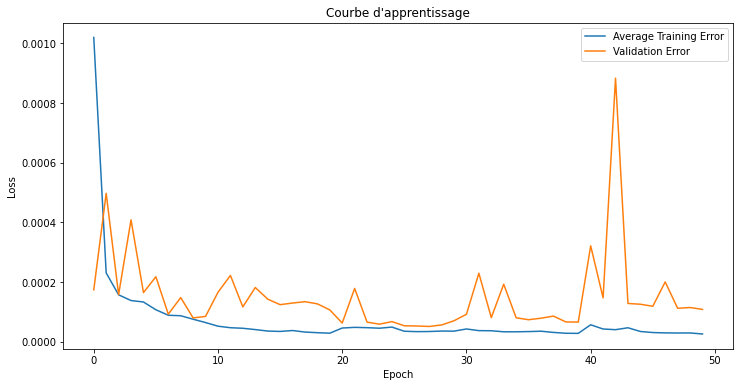

Fold 1 Validation Score: 0.0002
Fold 2 Validation Score: 0.0005
Fold 3 Validation Score: 0.0002
Fold 4 Validation Score: 0.0004
Fold 5 Validation Score: 0.0002
Fold 6 Validation Score: 0.0002
Fold 7 Validation Score: 0.0001
Fold 8 Validation Score: 0.0001
Fold 9 Validation Score: 0.0001
Fold 10 Validation Score: 0.0001
Fold 11 Validation Score: 0.0002
Fold 12 Validation Score: 0.0002
Fold 13 Validation Score: 0.0001
Fold 14 Validation Score: 0.0002
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0001
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0001
Fold 22 Validation Score: 0.0002
Fold 23 Validation Score: 0.0001
Fold 24 Validation Score: 0.0001
Fold 25 Validation Score: 0.0001
Fold 26 Validation Score: 0.0001
Fold 27 Validation Score: 0.0001
Fold 28 Validation Score: 0.0001
Fold 29 Validation Score: 0.0001
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

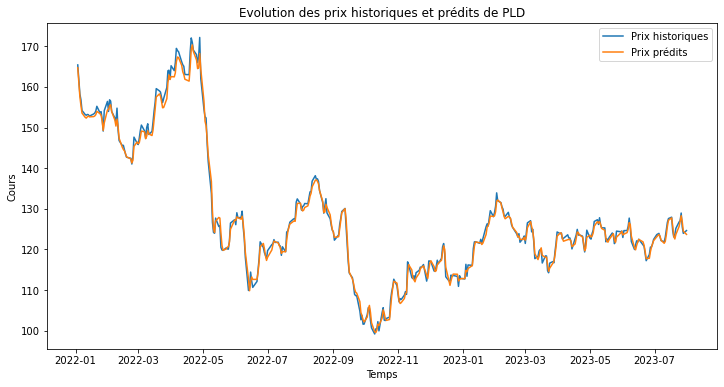

21 actions réalisées sur 22
2817
(395, 126, 1)
(387, 1)
(382, 1)
8/8 [==============================] - 0s 37ms/step
(769, 1)
(382, 1)
8/8 [==============================] - 0s 45ms/step
(1151, 1)
(382, 1)
8/8 [==============================] - 0s 40ms/step
(1533, 1)
(382, 1)
8/8 [==============================] - 0s 48ms/step
(1915, 1)
(382, 1)
8/8 [==============================] - 0s 42ms/step


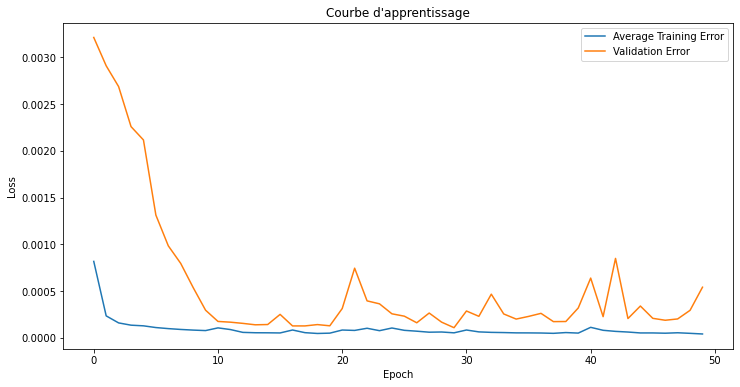

Fold 1 Validation Score: 0.0032
Fold 2 Validation Score: 0.0029
Fold 3 Validation Score: 0.0027
Fold 4 Validation Score: 0.0023
Fold 5 Validation Score: 0.0021
Fold 6 Validation Score: 0.0013
Fold 7 Validation Score: 0.0010
Fold 8 Validation Score: 0.0008
Fold 9 Validation Score: 0.0005
Fold 10 Validation Score: 0.0003
Fold 11 Validation Score: 0.0002
Fold 12 Validation Score: 0.0002
Fold 13 Validation Score: 0.0002
Fold 14 Validation Score: 0.0001
Fold 15 Validation Score: 0.0001
Fold 16 Validation Score: 0.0003
Fold 17 Validation Score: 0.0001
Fold 18 Validation Score: 0.0001
Fold 19 Validation Score: 0.0001
Fold 20 Validation Score: 0.0001
Fold 21 Validation Score: 0.0003
Fold 22 Validation Score: 0.0007
Fold 23 Validation Score: 0.0004
Fold 24 Validation Score: 0.0004
Fold 25 Validation Score: 0.0003
Fold 26 Validation Score: 0.0002
Fold 27 Validation Score: 0.0002
Fold 28 Validation Score: 0.0003
Fold 29 Validation Score: 0.0002
Fold 30 Validation Score: 0.0001
Fold 31 Validation 

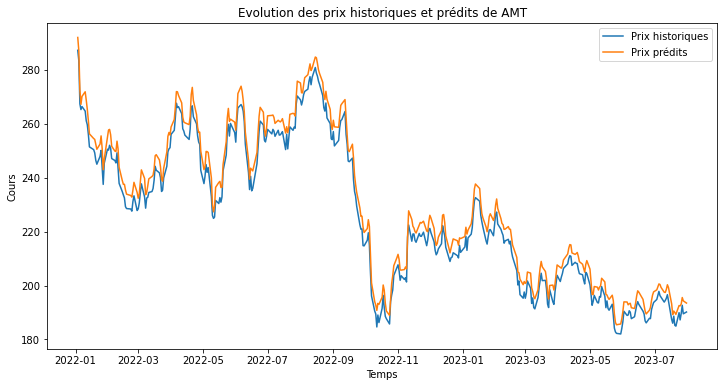

22 actions réalisées sur 22


In [68]:
# Chargement des données 
data = getData()
nombre_actions = 0
for symbol in data.columns :
    data_stock = data[[symbol]]
    data_adjusted = lissage_exponentiel(data_stock, 0.85)

    prediction_prix (data_adjusted, fenetre = 126, pct_train = 0.8155 , ticker = symbol, nb_plis= 5)
    nombre_actions = nombre_actions + 1
    print(str(nombre_actions)+ ' actions réalisées sur 22')

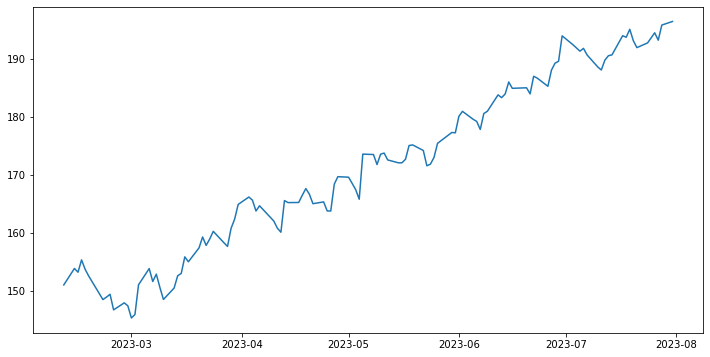

In [16]:
data = getData()
data = data[['AAPL']]
plt.figure(figsize=(12, 6))
plt.plot(data[2700:])

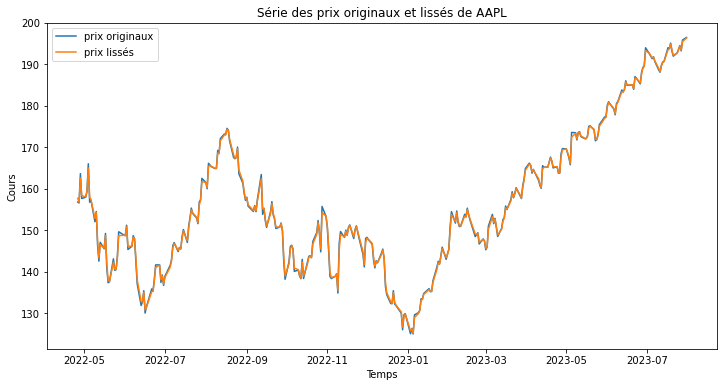

In [21]:
# Lissage des prix journaliers afin de ne pas entrainer le modèle à détecter trop de bruit
databis = lissage_exponentiel(data, 0.85)
plt.figure(figsize=(12, 6))
plt.plot(data[2500:], label = 'prix originaux')
plt.plot(databis[2500:], label = 'prix lissés')
plt.xlabel('Temps')
plt.ylabel('Cours')
plt.title('Série des prix originaux et lissés de AAPL')
plt.legend()


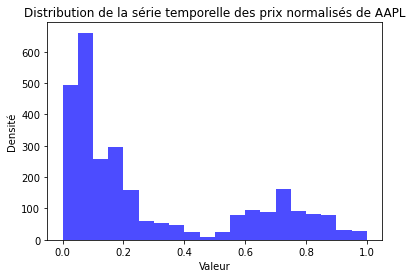

In [22]:
# Graph qui affiche la repartition des données normailisées
plt.hist(data_scaled, bins=20, density=False, alpha=0.7, color='blue')

# Ajoutez des étiquettes et un titre
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.title('Distribution de la série temporelle des prix normalisés de AAPL')

# Affichez l'histogramme
plt.show()




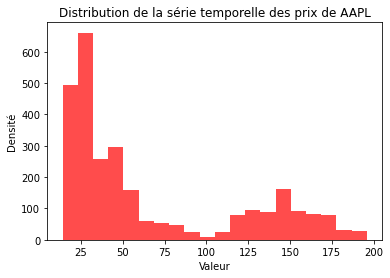

In [21]:
# Graph qui affiche la repartition des données normailisées
plt.hist(np.array(data[['AAPL']]), bins=20, density=False, alpha=0.7, color='red')
# Ajoutez des étiquettes et un titre
plt.xlabel('Valeur')
plt.ylabel('Densité')
plt.title('Distribution de la série temporelle des prix de AAPL')

# Affichez l'histogramme
plt.show()

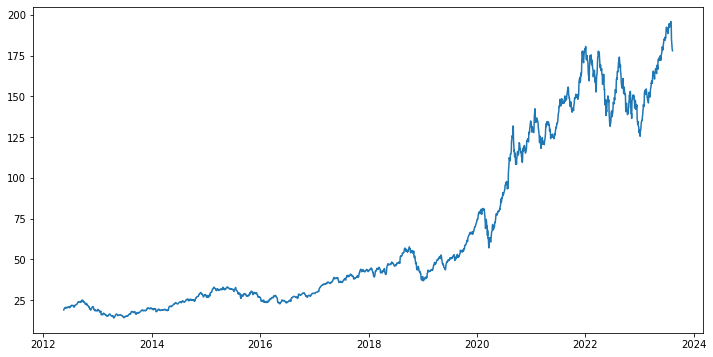

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(data)

In [30]:

# Sélectionner la colonne des prix de clôture comme étiquettes (y)
y = data_scaled

# Diviser les données en ensembles d'entraînement et de test (80% d'entraînement, 20% de test)
pct_train = 0.8
split_index = int(len(y) * (pct_train))
y_train, y_test = y[:split_index], y[split_index:]


# Paramètres pour la validation croisée
nb_plis = 5  # Nombre de plis pour la validation croisée
fenetre = 126  # Longueur de la séquence temporelle

# Préparation des données de test pour les séquences temporelles
X_test = [y_test[i:i+fenetre] for i in range(len(y_test) - fenetre)]
X_test = np.array(X_test)

# Créer un objet TimeSeriesSplit pour la validation croisée Day Forward-Chaining
tscv = TimeSeriesSplit(n_splits=nb_plis)


Text(0.5, 1.0, 'Illustration de la séparation du jeu de donnée')

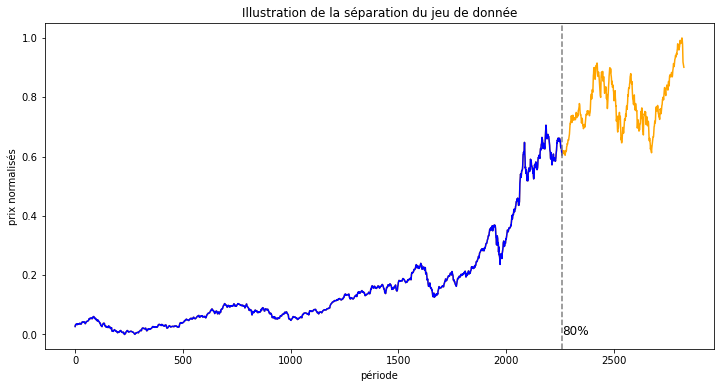

In [42]:
from matplotlib.colors import LinearSegmentedColormap


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data_scaled, label = 'Prix test', color = 'orange')
ax.plot(y_train, label = 'Prix entrainement', color = 'blue')
ax.axvline(x =  split_index, color = 'gray', linestyle = '--')
# Création d'un dégradé de couleurs pour la barre


# Affichage de la barre en couleur dégradée

ax.text(split_index, min(data_scaled), '80%', fontsize = 12)
ax.set_xlabel('période')
ax.set_ylabel('prix normalisés')
ax.set_title('Illustration de la séparation du jeu de donnée')


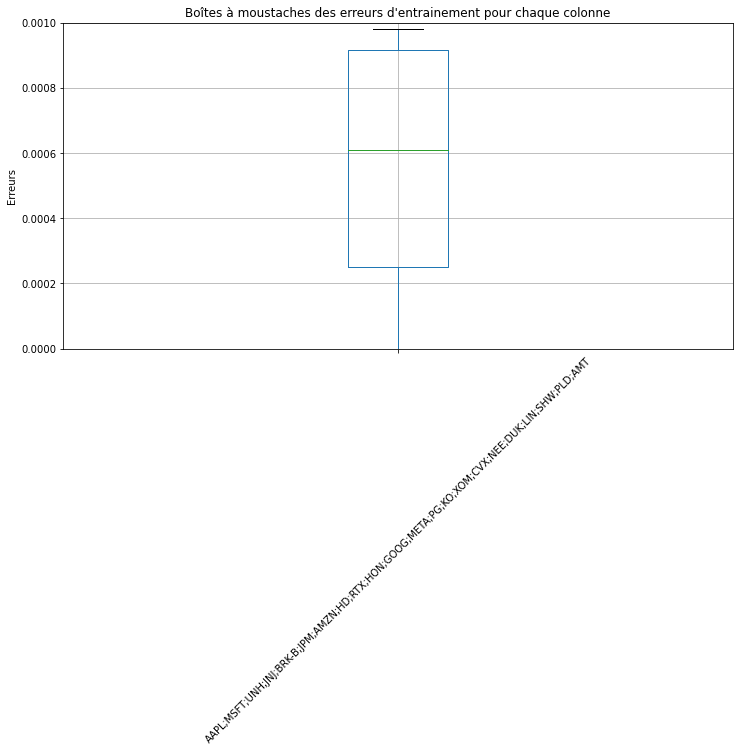

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('erreurs_train.csv')
data.describe()
# Utilisez la fonction boxplot de Pandas pour créer les boîtes à moustaches
intervalle_y = (0, 0.001)
data.boxplot(figsize=(12, 6))  # Réglez la taille de la figure selon vos préférences
plt.ylim(intervalle_y)
plt.title("Boîtes à moustaches des erreurs d'entrainement pour chaque colonne")
plt.ylabel('Erreurs')
plt.xticks(rotation=45)  # Rotation des étiquettes d'axe x si nécessaire
plt.show()

In [3]:
data = pd.read_csv('erreurs_train.csv')
data

AAPL;MSFT;UNH;JNJ;BRK-B;JPM;AMZN;HD;RTX;HON;GOOG;META;PG;KO;XOM;CVX;NEE;DUK;LIN;SHW;PLD;AMT
0 000148576;0 000171065;0 000335259;0 010596571;0 003391296;0 005570376;0 000227073;0 0016258;0   034320161;0 003928963;0 00097966;0  000652332;0 007561357;0 003682548;0 141158223;0 101298094;0 000848383;0 008418108;0 001191627;0 001545564;0 001019689;0                                       816955.00000                                          
7 31E-05;6    72E-05;0    000176166;0 001683676;0 000663134;0 000685481;0 000100012;0 000260793;0 005247432;0 000696667;0 000327849;0 000254253;0 000954077;0 001478044;0 015314372;0 013011831;0 000362011;0 001786857;0 000247402;0 000211428;0 000230305;0                                       234528.00000                                          
4 47E-05;3    12E-05;0    000124748;0 001103627;0 000403619;0 000433895;6 08E-05;0    000183393;0 002654715;0 000420202;0 000177878;0 00013771;0  000727959;0 000979708;0 008309008;0 006617303;0 000228339;0 001170759;0 000142732;0 000154787;0 000157057;0                                        15936.00000                                          
2 63E-05;1    36E-05;6    07E-05;0    000757791;0 000281857;0 000333281;4 04E-05;0    000129327;0 001420102;0 000331776;0 000149874;0 000116558;0 000537041;0 000723535;0 002775738;0 00138993;0  000172245;0 001111311;0 000102567;0 000131928;0 000137791;0                                       135145.00000                                          
1 57E-05;1    62E-05;2    27E-05;0    000430556;0 000153403;0 000281991;2 73E-05;0    000127164;0 001016267;0 000213851;0 000114818;6 31E-05;0    00042773;0  000625329;0 000907326;0 000880958;0 000109502;0 000909312;7 83E-05;9    85E-05;0    000132964;0                                       128095.00000                                          
  73E-05;1    28E-05;2    12E-05;0    000273381;8 05E-05;0    000243151;1 37E-05;0    000102867;0 000769915;0 00011582;8  82E-05;4    66E-05;0    000363927;0 000559277;0 000582255;0 000719065;5 83E-05;0    000777332;5 77E-05;9    71E-05;0    000106894;0                                       109666.00000                                          
2 24E-05;1    24E-05;1    53E-05;0    000205362;5 14E-05;0    000202015;1 20E-05;8    80E-05;0    000600745;7 49E-05;5    57E-05;4    80E-05;0    000322048;0 00052942;0  000471717;0 000521186;3 59E-05;0    000719952;3 96E-05;7    98E-05;8    85E-05;9                                               0.00084                                          
              09E-05;1    59E-05;0    000192917;3 71E-05;0    000169907;8 62E-06;7    06E-05;0    00052026;5  55E-05;3    64E-05;6    15E-05;0    000293619;0 000504706;0 000423608;0 000449663;3 41E-05;0    000673127;3 26E-05;7    18E-05;8    69E-05;8                                               0.00094                                          
1 88E-05;1    21E-05;1    83E-05;0    000193344;3 73E-05;0    000149855;8 08E-06;5    04E-05;0    000504467;5 73E-05;3    17E-05;4    98E-05;0    000260047;0 000534534;0 000385993;0 000385539;3 03E-05;0    000637639;3 21E-05;6    06E-05;7    52E-05;8                                               0.00025                                          
  41E-05;1    01E-05;1    58E-05;0    000197532;3 79E-05;0    000126548;8 74E-06;3    68E-05;0    000505278;5 47E-05;3    58E-05;4    19E-05;0    00024159;0  000466561;0 0003674;0   000389291;3 02E-05;0    000594443;3 14E-05;5    13E-05;6    40E-05;7                                               0.00074                                          
  69E-05;1    36E-05;2    22E-05;0    000242515;6 05E-05;0    000152389;1 92E-05;6    52E-05;0    000571685;7 84E-05;3    13E-05;4    70E-05;0    000200336;0 000648662;0 000753292;0 000726864;4 20E-05;0    000717891;5 94E-05;0    000215348;5 18E-05;0                                          106201.00000                                          
  54E-05;1    18E-05;2    31E-05;0    000259063;6 22E-05;0    000120624;1 55E-05;4    80E-0

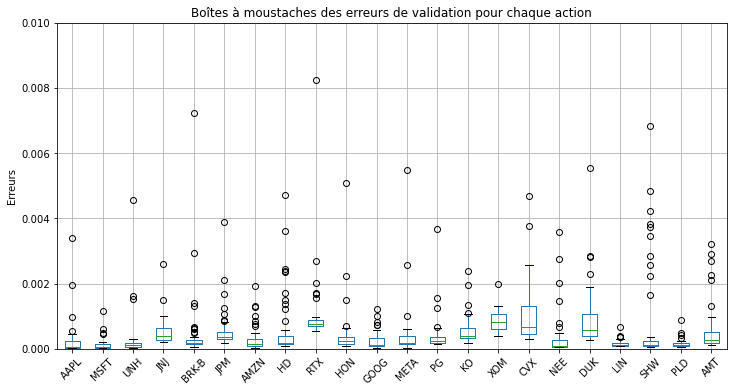

In [4]:
data = pd.read_csv('validation_scores.csv')
# Utilisez la fonction boxplot de Pandas pour créer les boîtes à moustaches
intervalle_y = (0, 0.01)
data.boxplot(figsize=(12, 6))  # Réglez la taille de la figure selon vos préférences
plt.ylim(intervalle_y)
plt.title("Boîtes à moustaches des erreurs de validation pour chaque action")
plt.ylabel('Erreurs')
plt.xticks(rotation=45)  # Rotation des étiquettes d'axe x si nécessaire
plt.show()

In [13]:
pd.DataFrame(data.mean(), columns=['Erreur moyenne de validation'])

,Erreur moyenne de validation
AAPL,0.000242
MSFT,0.000114
UNH,0.000272
JNJ,0.000717
BRK-B,0.000457
JPM,0.000559
AMZN,0.000295
HD,0.000602
RTX,0.001263
HON,0.000412


In [10]:
data.mean()

AAPL     0.000242
MSFT     0.000114
UNH      0.000272
JNJ      0.000717
BRK-B    0.000457
JPM      0.000559
AMZN     0.000295
HD       0.000602
RTX      0.001263
HON      0.000412
GOOG     0.000243
META     0.000413
PG       0.000377
KO       0.000557
XOM      0.002273
CVX      0.001558
NEE      0.000356
DUK      0.001125
LIN      0.000163
SHW      0.000831
PLD      0.000150
AMT      0.000559
dtype: float64